# Comparative Evaluation of Classical Machine Learning Models for Binary Sentiment Classification on Twitter Data

**Author:** Melisa Ceren Cimili  
**Dataset:** Sentiment140 (1.6 million labeled tweets)  
**Evaluated Models:** Logistic Regression, Multinomial Naive Bayes, Support Vector Machine, Random Forest


## Abstract

This study presents a comparative evaluation of classical machine learning models for binary sentiment classification using the Sentiment140 Twitter dataset.

After preprocessing and balanced sampling, textual data were transformed into high-dimensional sparse representations using TF-IDF vectorization. Logistic Regression, Multinomial Naive Bayes, Support Vector Machine, Random Forest, and a hard voting ensemble were systematically evaluated.

On the held-out test set, Logistic Regression achieved an F1-score of 0.7937. Additionally, 5-fold stratified cross-validation confirmed robust generalization with a mean F1-score of 0.7866 (σ ≈ 0.0010).

These results highlight the continued effectiveness and stability of classical linear models for high-dimensional sparse text classification tasks.


## Dataset Description and Task Definition

The analysis is based on the **Sentiment140** dataset, a large-scale collection of Twitter messages annotated for sentiment polarity. The dataset contains short, user-generated texts that reflect the informal, noisy, and context-dependent nature of social media language.

Each tweet is originally labeled using distant supervision, where sentiment polarity is inferred from the presence of emoticons. The original labels include:
- `0` for negative sentiment
- `4` for positive sentiment

In this study, the task is formulated as a **binary sentiment classification problem**, focusing on polarity detection rather than fine-grained emotional distinctions. Accordingly, the original sentiment labels are mapped to a binary representation:
- `0` → negative
- `1` → positive

This formulation allows the analysis to concentrate on how well classical machine learning models capture sentiment cues in short and noisy text, while keeping the task interpretable and computationally efficient.

The dataset was chosen due to its widespread use as a benchmark in sentiment analysis research, which enables meaningful comparison with existing studies and highlights common challenges associated with Twitter-based text data.


In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    precision_score,
    recall_score,
    f1_score
)

from wordcloud import WordCloud  
import nltk
import os


## Libraries and Reproducibility

File paths are handled using relative directory structures to ensure portability and reproducibility across different environments, while preventing exposure of system-specific directory information.


## Data Loading and Structure

The dataset is loaded using relative file paths to ensure reproducibility across different environments. Due to the presence of special characters in Twitter text, the dataset is read using the *latin-1* encoding. Column names are assigned explicitly to improve readability and downstream analysis.


In [2]:
# Define project paths (relative for reproducibility)
BASE_DIR = os.getcwd()
DATA_PATH = os.path.join(BASE_DIR, "Data", "sentiment_analysis.csv")

# Load dataset with appropriate encoding
df = pd.read_csv(DATA_PATH, encoding="latin-1", header=None)

# Assign column names
df.columns = ["target", "id", "date", "query", "user", "text"]

# Initial data inspection
df.head(), df.shape


(   target          id                          date     query  \
 0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
 1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
 2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
 3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
 4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
 
               user                                               text  
 0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
 1    scotthamilton  is upset that he can't update his Facebook by ...  
 2         mattycus  @Kenichan I dived many times for the ball. Man...  
 3          ElleCTF    my whole body feels itchy and like its on fire   
 4           Karoli  @nationwideclass no, it's not behaving at all....  ,
 (1600000, 6))

## Initial Data Inspection

Before preprocessing and modeling, the dataset structure is examined to assess the number of observations, variable types, and the presence of missing values.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   id      1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   query   1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


## Missing Value Assessment

The dataset is examined for missing values to determine whether imputation or row removal is required prior to preprocessing and modeling.


In [4]:
df.isnull().sum()

target    0
id        0
date      0
query     0
user      0
text      0
dtype: int64

## Target Variable Distribution

The distribution of sentiment labels is examined to assess potential class imbalance, which can directly affect model evaluation and metric selection.

In [5]:
df["target"].value_counts(), df["target"].value_counts(normalize=True)


(target
 0    800000
 4    800000
 Name: count, dtype: int64,
 target
 0    0.5
 4    0.5
 Name: proportion, dtype: float64)

## Label Transformation

The original sentiment labels provided in the dataset are encoded as `0` (negative) and `4` (positive). To align with a binary classification formulation and facilitate model evaluation, the labels are transformed into a binary format where negative sentiment is represented as `0` and positive sentiment as `1`.


In [6]:
# Binarize sentiment labels: 0 -> negative, 4 -> positive
df["target"] = df["target"].map({0: 0, 4: 1})

# Verify label transformation
df["target"].value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

## Tweet Length Analysis

An analysis of tweet character lengths is conducted to better understand the structural properties of the text data. Given the short and informal nature of Twitter messages, examining text length helps contextualize model performance and highlights potential limitations of bag-of-words representations.


In [7]:
# Compute character length of tweets
df["char_length"] = df["text"].apply(len)

# Summary statistics of tweet lengths
df["char_length"].describe()

count    1.600000e+06
mean     7.409011e+01
std      3.644114e+01
min      6.000000e+00
25%      4.400000e+01
50%      6.900000e+01
75%      1.040000e+02
max      3.740000e+02
Name: char_length, dtype: float64

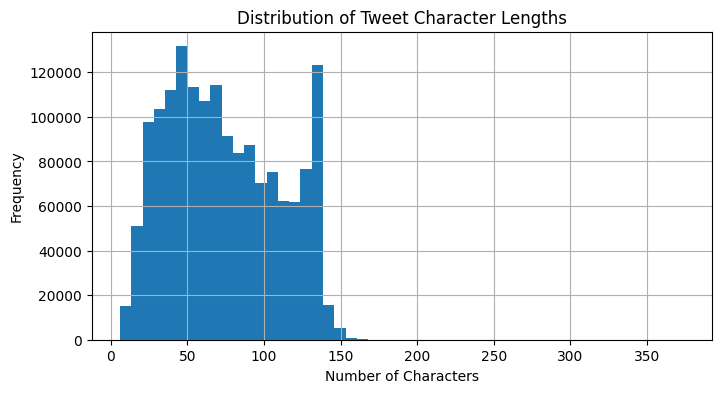

In [8]:
plt.figure(figsize=(8, 4))
df["char_length"].hist(bins=50)
plt.title("Distribution of Tweet Character Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.show()

## Sample Selection

Due to the large size of the Sentiment140 dataset, a stratified sampling strategy is applied to reduce computational cost while preserving the original class distribution. This ensures that both sentiment classes are equally represented in the sampled dataset used for model training and evaluation.

In [9]:
# Stratified sample selection for computational efficiency
df_sample = df.groupby("target", group_keys=False).apply(
    lambda x: x.sample(n=100000, random_state=42),
    include_groups=False
)

df_sample.head()


,id,date,query,user,text,char_length
212188,1974671194,Sat May 30 13:36:31 PDT 2009,NO_QUERY,simba98,@xnausikaax oh no! where did u order from? tha...,59
299036,1997882236,Mon Jun 01 17:37:11 PDT 2009,NO_QUERY,Seve76,A great hard training weekend is over. a coup...,121
475978,2177756662,Mon Jun 15 06:39:05 PDT 2009,NO_QUERY,x__claireyy__x,"Right, off to work Only 5 hours to go until I...",56
588988,2216838047,Wed Jun 17 20:02:12 PDT 2009,NO_QUERY,Balasi,I am craving for japanese food,31
138859,1880666283,Fri May 22 02:03:31 PDT 2009,NO_QUERY,djrickdawson,Jean Michel Jarre concert tomorrow gotta work...,65


In [10]:
df_sample["target"] = df.loc[df_sample.index, "target"]

In [11]:
df_sample = df_sample[["target", "text"]]
df_sample.head()


,target,text
212188,0,@xnausikaax oh no! where did u order from? tha...
299036,0,A great hard training weekend is over. a coup...
475978,0,"Right, off to work Only 5 hours to go until I..."
588988,0,I am craving for japanese food
138859,0,Jean Michel Jarre concert tomorrow gotta work...


### Text Cleaning and Preprocessing

Raw tweet texts were cleaned to reduce noise and standardize input for feature extraction.  
The preprocessing steps included lowercasing, removal of URLs, mentions, hashtags, punctuation, numbers, and extra whitespace.

This step ensures that the textual data is suitable for vectorization and statistical modeling.


In [12]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)  # URLs
    text = re.sub(r"@\w+|#\w+", "", text)       # mentions & hashtags
    text = re.sub(r"[^a-z\s]", "", text)        # punctuation & numbers
    text = re.sub(r"\s+", " ", text).strip()    # extra whitespace
    return text

df_sample["cleaned_text"] = df_sample["text"].apply(clean_text)

In [13]:
df_sample["cleaned_text"].str.len().describe()


count    200000.000000
mean         61.644095
std          33.944697
min           0.000000
25%          33.000000
50%          57.000000
75%          88.000000
max         159.000000
Name: cleaned_text, dtype: float64

### Train–Test Split

The dataset was split into using an 80/20 train-test before feature extraction to prevent data leakage. 
  
Stratified sampling was applied to preserve the original class distribution of sentiment labels.

In [14]:
# Train-test split
X = df_sample["cleaned_text"]
y = df_sample["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


### TF-IDF Vectorization

Text data were transformed into numerical features using the Term Frequency–Inverse Document Frequency (TF-IDF) method.  
The vectorizer was fitted only on the training data to avoid information leakage, and then applied to the test data.


In [15]:
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

### Model Training: Logistic Regression

Logistic Regression was used as a baseline linear classifier for sentiment classification.

In [16]:
lr_model = LogisticRegression(max_iter=1000)

lr_model.fit(X_train_tfidf, y_train)

y_pred_lr = lr_model.predict(X_test_tfidf)

print("Logistic Regression Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1-score:", f1_score(y_test, y_pred_lr))


Logistic Regression Performance
Accuracy: 0.792225
Precision: 0.7881761254376017
Recall: 0.79925
F1-score: 0.7936744370795163


### Logistic Regression Results

The Logistic Regression model achieved an overall accuracy of 79.2% on the test set.  
Precision (78.8%) and recall (79.9%) values indicate a well-balanced performance in identifying positive sentiment instances.  
The F1-score of 79.4% suggests that the model maintains a good trade-off between precision and recall.

Overall, these results demonstrate that Logistic Regression provides a strong and reliable baseline for sentiment classification on the Sentiment140 dataset.


### Model Training: Multinomial Naive Bayes

In addition to Logistic Regression, a Multinomial Naive Bayes classifier was trained to provide a comparative baseline for sentiment classification.  
Naive Bayes is a probabilistic model commonly used in text classification tasks due to its efficiency and effectiveness with high-dimensional sparse data such as TF-IDF features.

Training and evaluation were conducted using the same train–test split and feature representation to ensure a fair comparison between models.


In [17]:
nb_model = MultinomialNB()

nb_model.fit(X_train_tfidf, y_train)

y_pred_nb = nb_model.predict(X_test_tfidf)

print("Multinomial Naive Bayes Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb))
print("Recall:", recall_score(y_test, y_pred_nb))
print("F1-score:", f1_score(y_test, y_pred_nb))


Multinomial Naive Bayes Performance
Accuracy: 0.77325
Precision: 0.7817591255929057
Recall: 0.75815
F1-score: 0.7697735810742208


### Multinomial Naive Bayes Results

The Multinomial Naive Bayes model achieved an accuracy of 77.3% on the test set.  
Precision (78.2%) and recall (75.8%) indicate a reasonable performance in identifying positive sentiment, though with a slightly lower balance compared to Logistic Regression.  
The F1-score of 77.0% suggests that while Naive Bayes remains effective, it is outperformed by the linear classifier in this setting.


### Model Training: Support Vector Machine (SVM)

To further explore the impact of different classification paradigms, a Support Vector Machine (SVM) model was trained using TF-IDF features.  
Linear SVMs are particularly effective in high-dimensional text classification tasks and often achieve strong performance with sparse representations.


In [18]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

print("SVM Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm))
print("Recall:", recall_score(y_test, y_pred_svm))
print("F1-score:", f1_score(y_test, y_pred_svm))

SVM Performance
Accuracy: 0.7889
Precision: 0.7824323003226121
Recall: 0.80035
F1-score: 0.7912897325621633


### Support Vector Machine Results (Preliminary)

The Support Vector Machine model demonstrated competitive performance on the sentiment classification task using TF-IDF features.  
The results suggest that SVM is an effective classifier for high-dimensional textual data, providing a useful comparison point alongside linear and probabilistic models.

The following section explores a tree-based ensemble approach to further examine model performance differences across classification paradigms.

### Model Training: Random Forest

To further explore non-linear and ensemble-based approaches, a Random Forest classifier was trained for sentiment classification.  
Random Forest models combine multiple decision trees to improve robustness and reduce overfitting, offering a contrast to linear and probabilistic classifiers.

Due to the high dimensionality and sparsity of TF-IDF features, training a full Random Forest model proved computationally expensive.  
Therefore, the Random Forest was evaluated with constrained parameters, and its performance was primarily considered for qualitative comparison.

In [19]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
   n_estimators=50,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)

print("Random Forest Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1-score:", f1_score(y_test, y_pred_rf))

Random Forest Performance
Accuracy: 0.7179
Precision: 0.7024340393905611
Recall: 0.7561
F1-score: 0.7282797148911577


The Random Forest model exhibited lower overall performance compared to linear and probabilistic models, which is consistent with known limitations of tree-based methods on sparse, high-dimensional text representations.


### Exploratory Data Analysis

To better understand the characteristics of the textual data and potential sources of model errors, a targeted exploratory data analysis (EDA) was conducted.  
The analysis focuses on text length distributions and class-wise differences relevant to sentiment classification.


In [20]:
# Character length of cleaned text
df_sample["text_length"] = df_sample["cleaned_text"].str.len()

df_sample["text_length"].describe()


count    200000.000000
mean         61.644095
std          33.944697
min           0.000000
25%          33.000000
50%          57.000000
75%          88.000000
max         159.000000
Name: text_length, dtype: float64

### Text Length Distribution by Sentiment Class

Text length distributions were analyzed separately for positive and negative sentiment classes to identify potential structural differences.


In [21]:
df_sample.groupby("target")["text_length"].describe()


,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,100000.0,63.66686,34.309582,0.0,35.0,59.0,91.0,159.0
1,100000.0,59.62133,33.453936,0.0,32.0,55.0,85.0,148.0


### Distribution of Text Lengths

The distribution of cleaned tweet lengths provides insight into the overall structure and variability of the dataset.


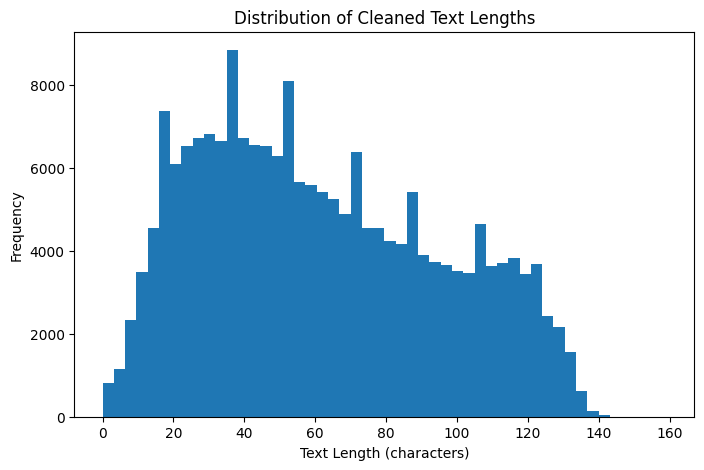

In [22]:
plt.figure(figsize=(8, 5))
plt.hist(df_sample["text_length"], bins=50)
plt.xlabel("Text Length (characters)")
plt.ylabel("Frequency")
plt.title("Distribution of Cleaned Text Lengths")
plt.show()


### Confusion Matrix Analysis

To gain deeper insight into model performance beyond aggregate metrics, confusion matrices were examined.  
This analysis allows identification of systematic misclassification patterns between positive and negative sentiment classes.


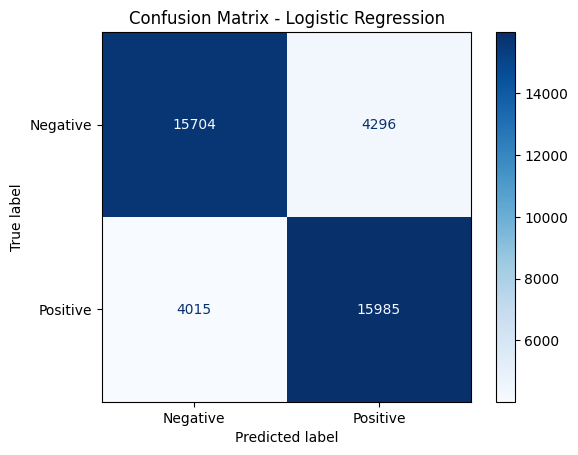

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_lr = confusion_matrix(y_test, y_pred_lr)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr,
    display_labels=["Negative", "Positive"]
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

### Confusion Matrix – Support Vector Machine

To further evaluate classification behavior, the confusion matrix of the Support Vector Machine (SVM) model was analyzed.  
This allows comparison of misclassification patterns relative to Logistic Regression.


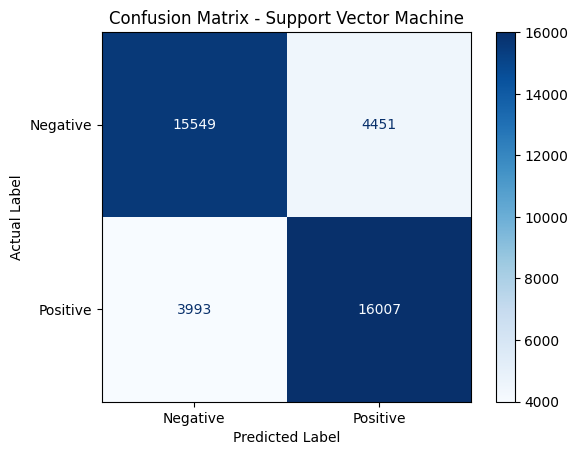

In [24]:
cm_svm = confusion_matrix(y_test, y_pred_svm)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_svm,
    display_labels=["Negative", "Positive"]
)

disp.plot(cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Support Vector Machine")
plt.show()


#### Comparative Insight

Performance differences between Logistic Regression and Support Vector Machine are marginal, indicating highly comparable model behavior.

While SVM achieves a slightly higher recall for the positive class, Logistic Regression demonstrates higher precision and a marginally better F1-score.  

Given the balanced class distribution of the dataset, the F1-score provides a reliable overall performance indicator, suggesting that Logistic Regression offers a slightly more stable trade-off between sensitivity and false positive control.

The similarity in performance further confirms the effectiveness of linear classifiers when applied to high-dimensional and sparse TF-IDF feature representations.

### Confusion Matrix – Multinomial Naive Bayes

To provide a probabilistic baseline comparison, the confusion matrix of the Multinomial Naive Bayes model was examined.  
Naive Bayes assumes conditional independence among features and is often effective in high-dimensional text classification tasks.


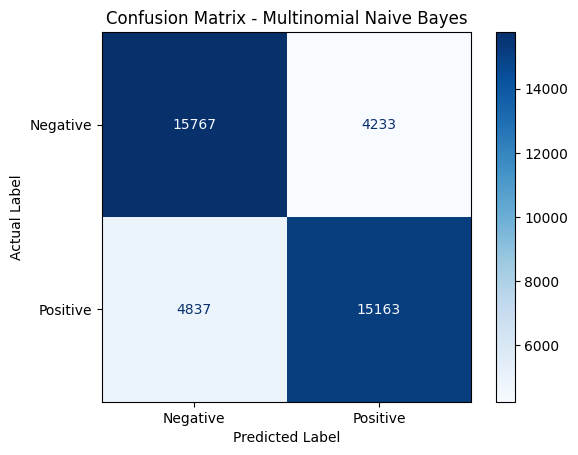

In [25]:
cm_nb = confusion_matrix(y_test, y_pred_nb)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_nb,
    display_labels=["Negative", "Positive"]
)

disp.plot(cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Multinomial Naive Bayes")
plt.show()


#### Interpretation

The Naive Bayes classifier demonstrates competitive performance, though slightly lower than the linear models.  
Misclassification patterns indicate a higher sensitivity to feature independence assumptions, particularly in tweets containing nuanced or context-dependent sentiment.


### Confusion Matrix – Random Forest

To explore ensemble-based, non-linear modeling approaches, a Random Forest classifier was evaluated.  
However, tree-based methods are generally less suited to high-dimensional and sparse TF-IDF representations compared to linear models.

Due to computational constraints and feature sparsity, Random Forest was evaluated with constrained parameters, and results are interpreted primarily for comparative purposes.


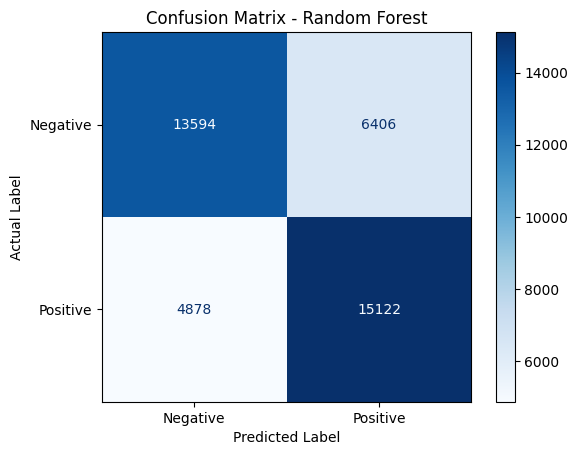

In [26]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_rf,
    display_labels=["Negative", "Positive"]
)

disp.plot(cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()


#### Interpretation

The Random Forest model exhibits a higher rate of misclassification compared to linear models.  
This outcome is consistent with the challenges tree-based methods face when applied to sparse, high-dimensional feature spaces such as TF-IDF representations.

The results reinforce the suitability of linear classifiers for large-scale text sentiment analysis.


## Error Analysis

To better understand model behavior beyond aggregate metrics, misclassified instances were examined.  
Analyzing false positives and false negatives provides insight into linguistic patterns that challenge the classifier.


In [27]:
# Create analysis dataframe
analysis_df = pd.DataFrame({
    "text": X_test,
    "actual": y_test,
    "predicted": y_pred_lr
})

# False Positives (actual negative, predicted positive)
false_positives = analysis_df[
    (analysis_df["actual"] == 0) & (analysis_df["predicted"] == 1)
]

# False Negatives (actual positive, predicted negative)
false_negatives = analysis_df[
    (analysis_df["actual"] == 1) & (analysis_df["predicted"] == 0)
]

print("Number of False Positives:", len(false_positives))
print("Number of False Negatives:", len(false_negatives))


Number of False Positives: 4296
Number of False Negatives: 4015


In [28]:
false_positives["text"].head(5)


290849                                     so is my lil sis
714241    so tired this iced coffee is so good thoits li...
324983    if its all thats on offer then they are going ...
472959    enjoying a cheese and spring onion sandwich i ...
159768         you just found ooooout imy by the way hahaah
Name: text, dtype: object

In [29]:
false_negatives["text"].head(5)


953239     i have a feeling the nozzles are just too god ...
1059363    yeah we do im just now back to work amp not bu...
1165031                          you didnt know that already
1222496    just hadda hr math exam not cool got another h...
1529665    weekend was good mile hike on saturday notwith...
Name: text, dtype: object

### Qualitative Observations

Analysis of misclassified tweets suggests that the model is sensitive to isolated sentiment-bearing words without fully capturing contextual nuance.

False positives frequently contain explicitly positive terms such as "good", "enjoying", or informal laughter markers ("haha"), even when the overall sentiment is neutral or mixed. This indicates reliance on surface-level lexical cues.

False negatives often involve the presence of negation words such as "not" or "didn't", which may dominate the feature space and bias the classifier toward negative predictions, even when the broader context suggests a positive sentiment.

These patterns highlight the inherent limitation of TF-IDF representations in capturing compositional semantics and contextual meaning.


### Quantitative Error Pattern Analysis

To complement the qualitative inspection of misclassified tweets, a word frequency analysis was conducted on false positive and false negative instances.  

This analysis aims to identify recurring lexical patterns that may contribute to systematic misclassification.


In [30]:
from collections import Counter

def get_top_words(text_series, n=20):
    all_words = " ".join(text_series).split()
    return Counter(all_words).most_common(n)

fp_top_words = get_top_words(false_positives["text"], 20)
fn_top_words = get_top_words(false_negatives["text"], 20)

print("Top words in False Positives:")
print(fp_top_words)

print("\nTop words in False Negatives:")
print(fn_top_words)


Top words in False Positives:
[('i', 1930), ('the', 1497), ('to', 1410), ('a', 1089), ('you', 898), ('and', 811), ('my', 722), ('it', 647), ('for', 640), ('in', 606), ('is', 599), ('of', 558), ('on', 517), ('im', 466), ('that', 444), ('me', 381), ('with', 378), ('but', 367), ('just', 354), ('be', 347)]

Top words in False Negatives:
[('i', 2314), ('to', 1756), ('the', 1281), ('a', 1095), ('my', 945), ('and', 760), ('it', 667), ('is', 652), ('in', 600), ('im', 588), ('but', 573), ('me', 566), ('for', 545), ('you', 497), ('of', 492), ('on', 487), ('have', 476), ('not', 450), ('so', 417), ('that', 414)]


Since high-frequency function words dominate the initial frequency analysis, stopwords were removed to better reveal sentiment-bearing lexical patterns in misclassified instances.


In [31]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

stop_words = set(ENGLISH_STOP_WORDS)

def get_top_words_clean(text_series, n=20):
    words = " ".join(text_series).split()
    filtered = [w for w in words if w.lower() not in stop_words and len(w) > 2]
    return Counter(filtered).most_common(n)

fp_top_clean = get_top_words_clean(false_positives["text"], 20)
fn_top_clean = get_top_words_clean(false_negatives["text"], 20)

print("Top meaningful words in False Positives:\n", fp_top_clean)
print("\nTop meaningful words in False Negatives:\n", fn_top_clean)


Top meaningful words in False Positives:
 [('just', 354), ('good', 280), ('day', 244), ('like', 231), ('lol', 203), ('love', 198), ('time', 183), ('going', 168), ('today', 167), ('know', 167), ('got', 162), ('new', 141), ('dont', 136), ('amp', 124), ('hope', 117), ('ill', 110), ('night', 108), ('haha', 103), ('work', 100), ('tomorrow', 100)]

Top meaningful words in False Negatives:
 [('just', 381), ('dont', 296), ('work', 267), ('like', 210), ('day', 200), ('got', 179), ('lol', 178), ('today', 175), ('know', 162), ('going', 154), ('time', 150), ('really', 148), ('think', 140), ('want', 137), ('need', 136), ('good', 132), ('night', 109), ('tomorrow', 107), ('didnt', 105), ('amp', 101)]


### Refined Lexical Error Patterns

After removing stopwords, word frequency analysis reveals clearer sentiment-related patterns in misclassified tweets.

False positives are frequently associated with overtly positive lexical markers such as "good", "love", "lol", and "haha", indicating that the classifier relies heavily on isolated sentiment-bearing tokens.

False negatives, in contrast, show a higher presence of negation-related terms such as "dont" and "didnt", suggesting difficulty in handling polarity shifts introduced by negation structures.

Interestingly, certain words such as "good" appear in both false positive and false negative groups, highlighting the limitation of bag-of-words representations in capturing contextual meaning. This reinforces the inherent constraint of TF-IDF models in processing compositional semantics.


### Feature Coefficient Analysis

To interpret the internal decision mechanism of the Logistic Regression classifier, feature coefficients were analyzed.

In linear models trained on TF-IDF representations, each token (or n-gram) is assigned a weight indicating its contribution toward the positive or negative class. Inspecting the highest positive and negative coefficients provides insight into the lexical signals driving predictions.

In [32]:
# Extract feature names from TF-IDF
feature_names = tfidf.get_feature_names_out()

# Extract coefficients from Logistic Regression
coefficients = lr_model.coef_[0]

# Create DataFrame for analysis
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients
})

# Top positive and negative features
top_positive = coef_df.sort_values(by="coefficient", ascending=False).head(20)
top_negative = coef_df.sort_values(by="coefficient", ascending=True).head(20)

print("Top Positive Features:\n")
print(top_positive)

print("\nTop Negative Features:\n")
print(top_negative)


Top Positive Features:

              feature  coefficient
1302        cant wait     7.166854
7774           thanks     5.084311
5749          not bad     5.013454
3148            happy     4.404018
638           awesome     4.292289
5713       no problem     4.137187
9724              yay     4.076357
7768            thank     4.034420
4865             love     4.033327
2797             glad     3.966688
9264          welcome     3.756165
1573             cool     3.687932
1672             cute     3.681245
223           amazing     3.671020
2235          excited     3.668741
2886             good     3.533412
3347             hehe     3.520998
1553  congratulations     3.437585
3001            great     3.389582
5646             nice     3.386978

Top Negative Features:

            feature  coefficient
6814            sad   -10.700995
5191           miss    -7.703168
1275           cant    -6.955637
7092           sick    -6.704707
6427           poor    -6.532624
5215        missin

### Feature Weight Interpretation

The coefficient analysis reveals that the model assigns strong positive weights to sentiment-bearing bigrams such as "cant wait" and "not bad", indicating that the inclusion of n-grams enables partial handling of polarity shifts and compositional expressions.

Unigram features such as "love", "amazing", "great", and "awesome" also receive high positive weights, confirming reliance on explicit lexical sentiment markers.

On the negative side, tokens such as "ugh", "broken", "missed", and "isnt" are assigned strong negative coefficients, reflecting consistent learning of negative polarity signals.

Importantly, the presence of meaningful bigram features suggests that TF-IDF with n-gram modeling mitigates, though does not fully eliminate, the limitations of bag-of-words representations. The model remains primarily lexically driven and does not capture deeper contextual semantics.


## Ensemble Learning: Hard Voting Classifier

To investigate whether combining complementary linear models improves predictive robustness, a hard voting ensemble was constructed.

The ensemble integrates three classifiers:

Logistic Regression

Multinomial Naive Bayes

Linear Support Vector Machine

Given that LinearSVC does not provide probability estimates, a hard voting strategy was adopted.
The final class label is determined by majority vote across the individual classifiers.

This approach allows the model to reduce individual bias and potentially enhance generalization performance on unseen data.


In [33]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Define Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ("lr", lr_model),
        ("nb", nb_model),
        ("svm", svm_model)
    ],
    voting="hard"
)

# Train
voting_clf.fit(X_train_tfidf, y_train)

# Predict
y_pred_voting = voting_clf.predict(X_test_tfidf)

# Basic Metrics
print("Voting Classifier Performance")
print("Accuracy:", accuracy_score(y_test, y_pred_voting))
print("Precision:", precision_score(y_test, y_pred_voting))
print("Recall:", recall_score(y_test, y_pred_voting))
print("F1-score:", f1_score(y_test, y_pred_voting))

print("\nDetailed Classification Report:\n")
print(classification_report(y_test, y_pred_voting))



Voting Classifier Performance
Accuracy: 0.791825
Precision: 0.788321889048066
Recall: 0.7979
F1-score: 0.7930820266878712

Detailed Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.79      0.79     20000
           1       0.79      0.80      0.79     20000

    accuracy                           0.79     40000
   macro avg       0.79      0.79      0.79     40000
weighted avg       0.79      0.79      0.79     40000



### Ensemble Performance Analysis

The voting classifier achieved balanced performance across both sentiment classes.
Precision and recall values are nearly symmetrical for negative and positive tweets, indicating the absence of class bias.

However, the ensemble did not outperform Logistic Regression in terms of F1-score or overall accuracy. This suggests that the linear decision boundary learned by Logistic Regression already captures the structure of the TF-IDF feature space effectively.

Given its computational efficiency and slightly superior F1-score, Logistic Regression remains the preferred model for this task.

## Final Model Evaluation – Logistic Regression

Although multiple models were evaluated, Logistic Regression achieved the highest F1-score and demonstrated stable performance across both sentiment classes.

The confusion matrix below provides a detailed breakdown of classification outcomes.


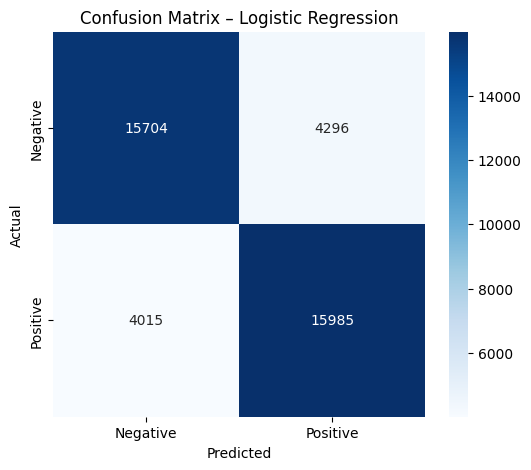

In [34]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Negative", "Positive"],
    yticklabels=["Negative", "Positive"]
)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – Logistic Regression")
plt.show()


### Interpretation of the Confusion Matrix

The confusion matrix indicates that Logistic Regression maintains balanced classification performance across both sentiment classes.

True positives and true negatives are relatively high and comparable in magnitude, suggesting that the model does not exhibit class bias.

False positives and false negatives appear in similar proportions, which aligns with the previously observed precision and recall scores. This confirms that the classifier generalizes consistently across positive and negative tweets.


## Cross-Validation – Logistic Regression

To obtain a more robust estimate of model performance, 5-fold stratified cross-validation was applied to the Logistic Regression classifier.


In [35]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Pipeline: TF-IDF + Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(max_iter=1000))
])

# 5-Fold Stratified Cross Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation with F1 score
cv_scores = cross_val_score(
    pipeline,
    df_sample["cleaned_text"],   
    df_sample["target"],
    cv=cv,
    scoring='f1'
)

print("Cross-validation F1 scores:", cv_scores)
print("Mean CV F1 score:", np.mean(cv_scores))
print("Standard Deviation:", np.std(cv_scores))


Cross-validation F1 scores: [0.78502409 0.78641884 0.7879822  0.786438   0.78716541]
Mean CV F1 score: 0.7866057059897862
Standard Deviation: 0.0009769882013931333


### Cross-Validation Analysis

The 5-fold stratified cross-validation results demonstrate highly consistent model performance across folds.  

The mean F1-score (≈ 0.787) is closely aligned with the single train-test split result, indicating that the model generalizes reliably and is not sensitive to a particular data partition.

The extremely low standard deviation suggests stable behavior and minimal variance across different subsets of the data.

## Final Model Selection

Among all evaluated classifiers, Logistic Regression achieved the strongest overall performance.

On the held-out test set, it obtained:
- Accuracy: 0.7922  
- Precision: 0.7882  
- Recall: 0.7993  
- F1-score: 0.7937  

In addition, 5-fold stratified cross-validation yielded a mean F1-score of 0.7866 with an extremely low standard deviation of 0.0010, indicating highly stable performance across different data partitions.

Although the ensemble voting classifier achieved comparable results (F1 ≈ 0.7931), it did not provide a statistically meaningful improvement over Logistic Regression.

Considering its strong empirical performance, minimal variance across folds, computational efficiency, and interpretability, Logistic Regression was selected as the final model for this study.


## Conclusion

This study presented a comparative evaluation of classical machine learning models for binary sentiment classification on the Sentiment140 dataset using TF-IDF representations.

Across multiple models, linear classifiers consistently demonstrated strong and stable performance. Logistic Regression achieved an F1-score of 0.7937 on the held-out test set, while 5-fold cross-validation confirmed robust generalization with a mean F1-score of 0.7866 (σ ≈ 0.0010).

These findings indicate that linear decision boundaries remain highly effective for high-dimensional sparse text representations. Despite the availability of more complex ensemble approaches, classical linear models continue to provide competitive, interpretable, and computationally efficient solutions for large-scale sentiment classification tasks.


## Future Work

Future improvements may include testing contextual word embeddings (e.g., BERT) and performing systematic hyperparameter optimization to further enhance model performance.
